<a href="https://colab.research.google.com/github/vcwild/imersao-dados/blob/main/Aula_04_Imersao_Dados_DF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## Set up default environment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# set options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
warnings.filterwarnings('ignore')

# set seed
seed = 42

## Download, unzip dataset, rename it and remove source

In [2]:
import zipfile

!wget https://github.com/alura-cursos/imersao-dados-2-2020/raw/master/por%20estado/df.csv.zip --no-check-certificate

path_to_zip_file = "df.csv.zip"
directory_to_extract_to = "./"

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

! rm df.csv.zip && mv df.csv.txt df.csv

--2020-10-23 01:39:52--  https://github.com/alura-cursos/imersao-dados-2-2020/raw/master/por%20estado/df.csv.zip
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alura-cursos/imersao-dados-2-2020/master/por%20estado/df.csv.zip [following]
--2020-10-23 01:39:53--  https://raw.githubusercontent.com/alura-cursos/imersao-dados-2-2020/master/por%20estado/df.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10285422 (9.8M) [application/zip]
Saving to: ‘df.csv.zip’

df.csv.zip          100%[===================>]   9.81M  58.7MB/s    in 0.2s    

2020-10-23 01:39:54 (58.7 MB/s) - ‘df.csv.zip’ saved [102

## Import dataset


In [3]:
df = pd.read_csv("df.csv", encoding="utf8", sep=";")
df.columns.sort

<bound method Index.sort of Index(['ID', ' NU_INSCRICAO', 'NU_ANO', 'CO_MUNICIPIO_RESIDENCIA',
       'NO_MUNICIPIO_RESIDENCIA', 'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA',
       'NU_IDADE', 'TP_SEXO', 'TP_ESTADO_CIVIL',
       ...
       'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024',
       'Q025 '],
      dtype='object', length=137)>

# Machine Learning

## Define features

In [4]:
exams = ["NU_NOTA_CN", "NU_NOTA_CH", "NU_NOTA_MT", "NU_NOTA_LC", "NU_NOTA_REDACAO"]
features = ["NU_NOTA_CH", "NU_NOTA_LC", "NU_NOTA_CN", "NU_NOTA_REDACAO"]
target = "NU_NOTA_MT"

exams_dropna = df[exams].dropna()
X = exams_dropna[features]
y = exams_dropna[target]

## Train-test split

In [5]:
from sklearn.model_selection import train_test_split as tts

X_train, X_test, y_train, y_test =  tts(X, y, test_size=0.25, random_state=seed)

## Apply Grid Search

In [6]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

seed = 42

pipeline = Pipeline([
    ('regressor', RandomForestRegressor())
])

search = [
    {
        'regressor': [LinearRegression(n_jobs=-1)],
        'regressor__normalize': ['False', 'True']
    },
    {
        'regressor': [Ridge(random_state=seed)],
        'regressor__alpha': [0.1, 0.5, 1],
        'regressor__normalize': ['False', 'True']
    },
    {
        'regressor': [Lasso(random_state=seed)],
        'regressor__alpha': [0.5, 1, 2],
        'regressor__normalize': ['False', 'True']
    }
]

clf = GridSearchCV(pipeline, search, cv=5, n_jobs=-1, scoring='r2')

### Train

In [7]:
best_fit = clf.fit(X_train, y_train)

In [8]:
best_fit.best_estimator_

Pipeline(memory=None,
         steps=[('regressor',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1,
                                  normalize='False'))],
         verbose=False)

In [9]:
best_fit.best_score_

0.5442280943981898

### Test

In [10]:
prediction = best_fit.predict(X_test)

## Validate

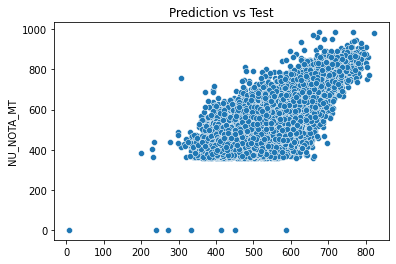

In [16]:
import matplotlib.pyplot as plt 
import seaborn as sns

sns.scatterplot(prediction, y_test)
plt.title("Prediction vs Test");

### Define Mean Absolute Error (MAE)

In [12]:
residuals = y_test - prediction
results = pd.DataFrame()

results["true"] = y_test
results["prediction"] = prediction
results["error"] = y_test - prediction
results["sq_error"] = (results.error)**2
results["abs_error"] = results.sq_error**(1/2)
mae = results.abs_error.mean()
mae

62.98245973484579

### Compare to sklearn MAE implementation

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# mean_squared_error(y_test, prediction, squared=False)
mean_absolute_error(y_test, prediction)

62.98245973484583

### Plot residuals

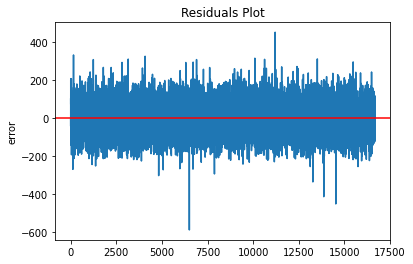

In [17]:
index = [i for i in range(len(prediction))]

sns.lineplot(index, results.error)
plt.axhline(0, color="r")
plt.title("Residuals Plot");